In [1]:
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from train_util import program_map, one_hot_map
import scipy

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 32000
sample_duration = 2 * sample_rate
n_fft = 2048
hop_length = int(n_fft / 4)
epsilon = 1.0e-6
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 2
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=107.192275, end=107.352987, pitch=69, velocity=93)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(10043769,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(64000,)
-0.0832016850974197


(1025, 126)
(-0.018544355+0j)


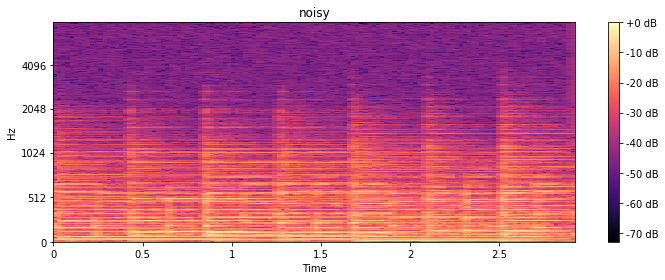

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft, hop_length=hop_length)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(1025, 126, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch  # TODO: make this one hot encoding
annotation[0,0,1] = note.end - note.start  # TODO: scale this
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 126, 2)
(1026, 126, 2)


In [10]:
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=instrument.is_drum)
iso_note = pretty_midi.Note(note.velocity, note.pitch, 0.0, 1)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 126)


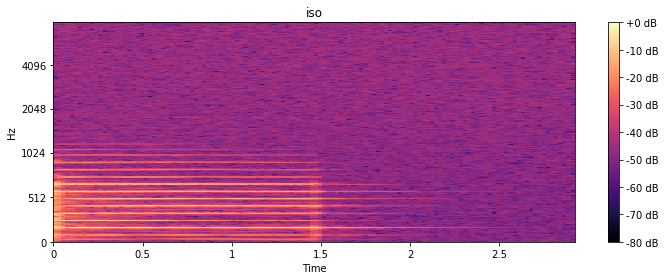

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft, hop_length=hop_length)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

mag unscaled [3.503146928096612e-08, 243.6580352783203]
lin_mel_matrix (1024, 1025)
mel_sq_mag (1024, 126)
mel_sq_mag range [0.0, 13952.355719740432]
scale factor 17.269388197455342
(1025, 1024)
(1025, 126)
mag unscaled [0.0, 59369.23828125]


/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


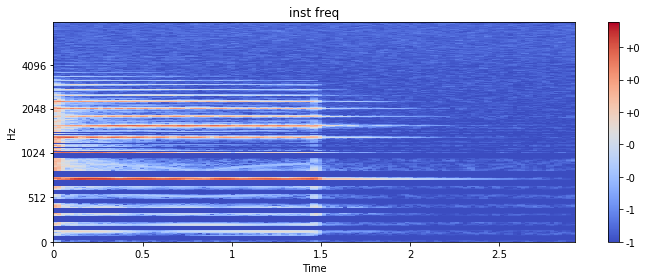

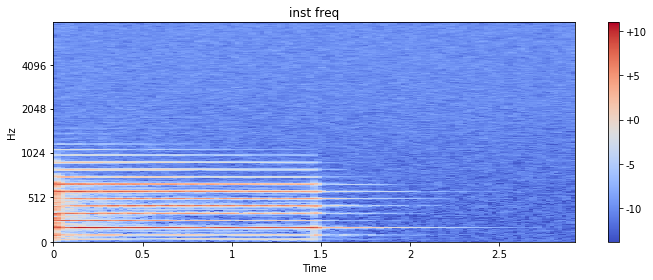

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)
print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))

mag_sq = np.square(magnitude)

def _mel_to_linear_matrix():
    """Get the inverse mel transformation matrix."""
    m = librosa.filters.mel(sample_rate, n_fft, n_mels=1024)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

# my stft: [freq, time]
# their stft: [time, frequency]

# my mel filter: [n_mel_bins, num_spectrogram_bins]
# their mel filter: [num_spectrogram_bins, n_mel_bins]

# their multiply: tf.tensordot(mag2, l2mel, 1)
# my multiply: along frequency

# apply mel scaling on phase angle and magnitude
lin_mel_matrix = librosa.filters.mel(sample_rate, n_fft, n_mels=1024)
print("lin_mel_matrix {}".format(lin_mel_matrix.shape))
mel_sq_mag = np.matmul(lin_mel_matrix, mag_sq)
print("mel_sq_mag {}".format(mel_sq_mag.shape))
print("mel_sq_mag range [{}, {}]".format(np.amin(mel_sq_mag), np.amax(mel_sq_mag)))

log_mel_sq_mag = np.log(mel_sq_mag + epsilon)
mag_scale_factor = max(np.abs(np.amin(log_mel_sq_mag)), np.amax(log_mel_sq_mag)) * 1.25
print("scale factor {}".format(mag_scale_factor))
final_mag = log_mel_sq_mag / mag_scale_factor

mel_lin_matrix = _mel_to_linear_matrix()
print(mel_lin_matrix.shape)
unscaled_mag = np.matmul(mel_lin_matrix, mel_sq_mag)
print(unscaled_mag.shape)
print("mag unscaled [{}, {}]".format(np.amin(unscaled_mag), np.amax(unscaled_mag)))

plt.figure(figsize=(10, 4))
librosa.display.specshow(final_mag, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(np.log(unscaled_mag+epsilon), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

phase unscaled [-3.1415927410125732, 3.1415927410125732]
(1025, 126)


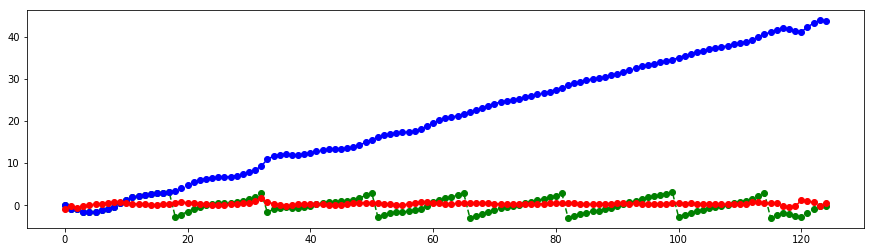

In [13]:
# unwrapped phase and instantaneous frequency!
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
unwrapped_phase = np.unwrap(phase)
print(unwrapped_phase.shape)
rev_unwrapped_phase = np.angle(np.exp(1j * unwrapped_phase))
# for some reason, some signs are flipped
# print(np.count_nonzero((rev_unwrapped_phase - phase) > 1e-04))
# assert np.allclose(np.abs(rev_unwrapped_phase), np.abs(phase), rtol=0, atol=1e-04)

inst_freq = np.diff(unwrapped_phase, axis=1)
rev_if = np.cumsum(np.concatenate((unwrapped_phase[:,:1], inst_freq), axis=1), axis=1)
# assert np.allclose(rev_if, unwrapped_phase)

mode, _ = scipy.stats.mode(np.argmax(magnitude, axis=0))
mode = mode[0]
plt.figure(figsize=(15, 4))
plt.plot(range(125), phase[mode,:125], '--go')
plt.plot(range(125), unwrapped_phase[mode,:125], '--bo')
plt.plot(range(125), inst_freq[mode,:125], '--ro')

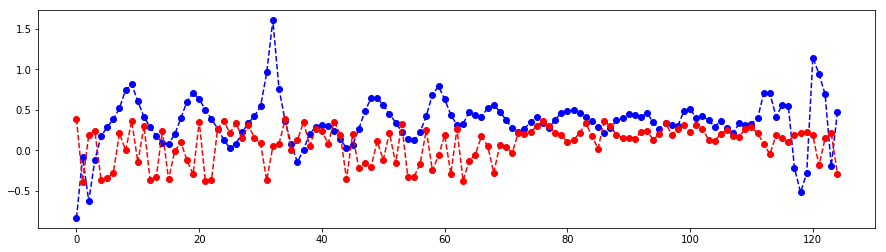

In [14]:
mel_unwrapped_phase = np.matmul(lin_mel_matrix, unwrapped_phase)
mel_inst_freq = np.diff(mel_unwrapped_phase, axis=1)
plt.figure(figsize=(15, 4))
plt.plot(range(125), inst_freq[mode,:125], '--bo')
plt.plot(range(125), mel_inst_freq[mode,:125], '--ro')

In [15]:
# scaled_phase = phase / (np.pi + epsilon)
print("ifreq unscaled [{}, {}]".format(np.amin(mel_inst_freq), np.amax(mel_inst_freq)))

phase_scale_factor = max(np.abs(np.amin(mel_inst_freq)), np.amax(mel_inst_freq)) * 1.25
print("scale factor {}".format(phase_scale_factor))
final_phase = mel_inst_freq / phase_scale_factor

print("ifreq scaled [{}, {}]".format(np.amin(final_phase), np.amax(final_phase)))

ifreq unscaled [-0.8629264476287142, 0.8702716980831307]
scale factor 1.0878396226039133
ifreq scaled [-0.7932478553807091, 0.8]


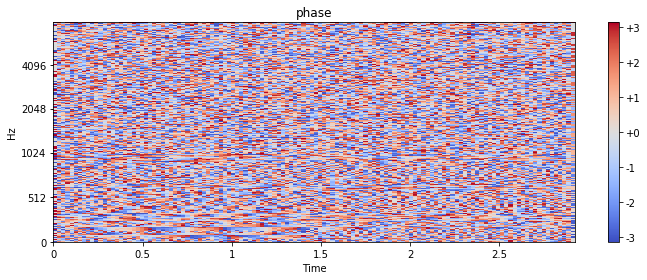

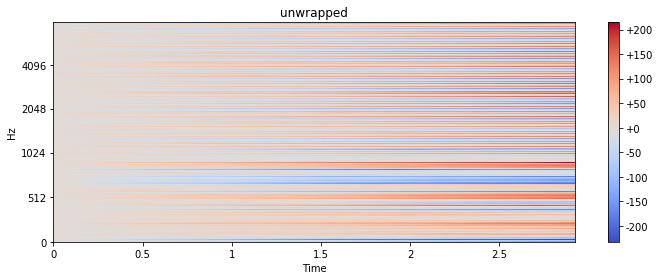

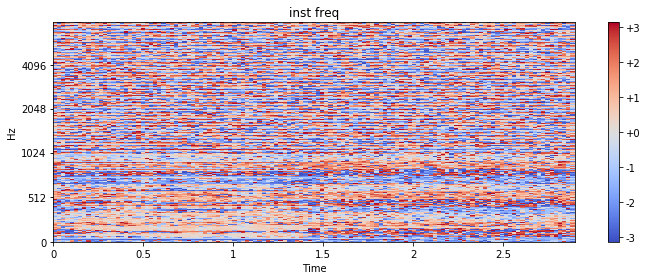

In [16]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('phase')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(unwrapped_phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('unwrapped')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(inst_freq, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

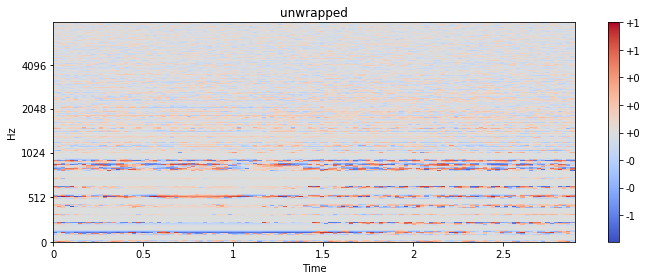

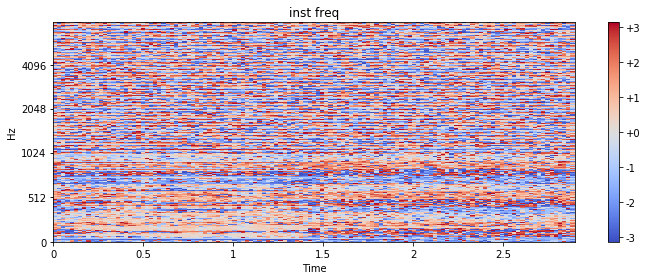

In [17]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(final_phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('unwrapped')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(inst_freq, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

og_mag [0.0, 243.6580355359741]


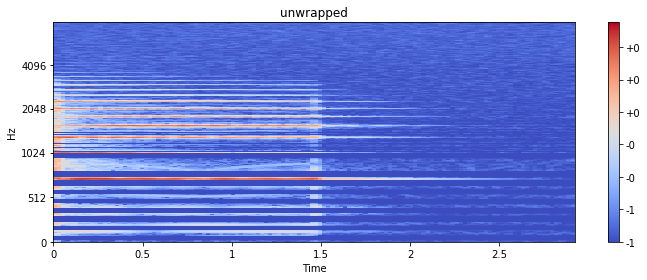

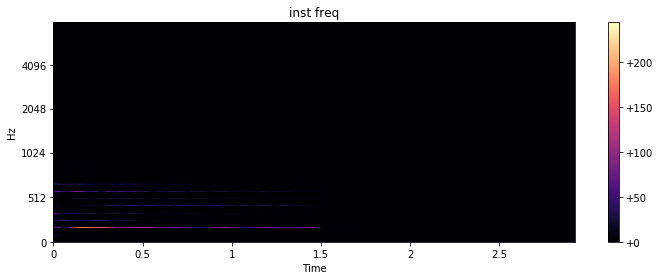

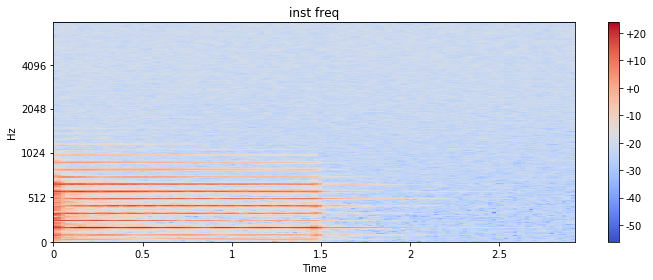

In [18]:
og_mag = final_mag * mag_scale_factor
og_mag = np.exp(og_mag) - epsilon
og_mag = np.matmul(mel_lin_matrix, og_mag)
og_mag = np.sqrt(og_mag)
print("og_mag [{}, {}]".format(np.amin(og_mag), np.amax(og_mag)))

plt.figure(figsize=(10, 4))
librosa.display.specshow(final_mag, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('unwrapped')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(og_mag, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(og_mag), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

og_phase [-3.141592566167014, 3.141592566167014]


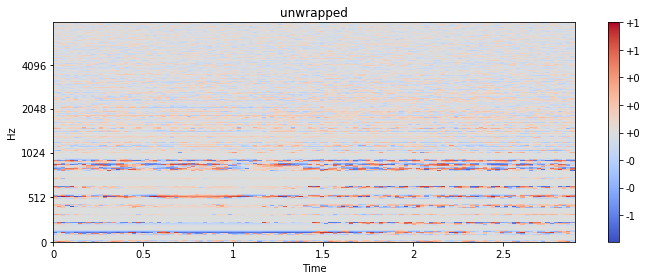

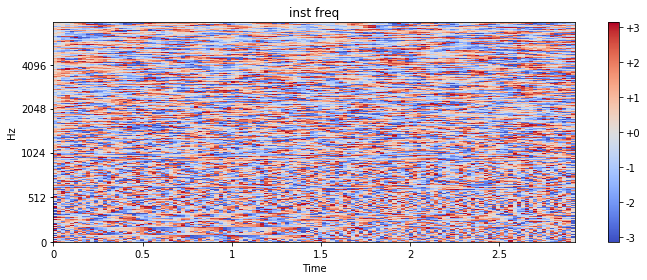

In [19]:
og_phase = final_phase * phase_scale_factor
og_phase = np.cumsum(np.concatenate((mel_unwrapped_phase[:,:1], og_phase), axis=1), axis=1)
og_phase = np.matmul(mel_lin_matrix, og_phase)
og_phase = np.angle(np.exp(1j * og_phase))
print("og_phase [{}, {}]".format(np.amin(og_phase), np.amax(og_phase)))

plt.figure(figsize=(10, 4))
librosa.display.specshow(final_phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('unwrapped')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(og_phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

In [20]:
og_stft = og_mag * np.exp(1j*og_mag)
og_audio = librosa.core.istft(og_stft)
ipd.Audio(og_audio, rate=sample_rate)